In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import l2

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score

In [ ]:
data_url = "https://raw.githubusercontent.com/darkreqnx/leaf-classifier/master/img_dataset.csv?token=AIOJSRNXUP63AVJTN7BI67267RU5I"
df = pd.read_csv(data_url)

In [ ]:
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
print(df.shape)
df.head(5)

(5163, 130)


,code,smoothness0,leaflet_desc0,leaflet_desc1,leaflet_desc2,leaflet_desc3,leaflet_desc4,leaflet_desc5,leaflet_desc6,gabor0,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,color0,color1,color2,color3,color4,color5,color6,color7,color8,color9,color10,color11,fft0,fft1,fft2,fft3,fft4,fft5,fft6,fft7,fft8,fft9,fft10,...,geom11,geom12,geom13,geom14,geom15,geom16,geom17,geom18,geom19,geom20,geom21,geom22,geom23,geom24,geom25,geom26,geom27,geom28,geom29,geom30,geom31,geom32,geom33,geom34,geom35,geom36,geom37,geom38,geom39,geom40,geom41,geom42,geom43,geom44,geom45,geom46,geom47,geom48,geom49,geom50
0,91,0.979536,0.143665,2.338776,31.485249,119.920807,286.525741,201.943061,1952.964150,0.911419,0.935342,0.966364,0.982179,0.979554,0.989804,0.961714,0.936957,0.000000,0.024793,0.703430,0.271572,0.000127,0.000077,0.000000,0.0,0.0,0.0,0.0,0,0.143883,0.151026,0.015281,0.020998,0.015228,0.030275,0.026927,0.045560,0.033871,0.065117,0.025546,...,0.876117,-0.251384,-0.460533,0.385065,-0.884786,0.851070,-0.719255,-0.393799,-0.338005,0.626295,0.302566,0.420510,0.086816,0.625788,0.642147,0.593797,0.522356,0.318266,-0.906291,-0.667784,-0.746709,-0.328224,-0.551312,-0.586206,0.415079,-0.195878,0.013096,-0.213238,-0.246976,-0.231880,-1.001535,1.732315,0.007073,-0.452981,-0.706923,-1.022245,-0.908407,-1.276710,-0.491594,0.578680
1,64,0.961877,0.056914,5.246406,42.601066,40.000000,259.557315,144.920668,4834.322407,1.126443,0.873785,0.727033,0.919192,0.920714,0.946161,0.770046,0.807833,0.000000,0.002018,0.705385,0.292597,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0.157291,0.158870,0.054195,0.055843,0.030066,0.030663,0.023949,0.023925,0.018166,0.017981,0.016671,...,1.147682,1.541241,-0.664053,-1.079146,-1.095471,-0.587644,1.324125,-0.317080,0.264945,-1.030624,-1.563605,-1.692671,-1.552787,-1.203767,-0.755655,-0.489387,-1.351919,-0.755483,-0.392455,0.031202,-0.746709,-0.328224,-0.551312,-0.461952,-1.002320,1.418241,0.828788,2.626090,-0.972674,-0.004475,-0.592506,-1.579048,1.392321,0.514588,1.559163,0.529380,0.051828,-0.516274,-1.283446,-0.423423
2,91,0.974892,0.214232,3.820022,58.629683,83.240615,267.421016,184.491192,1905.605169,0.776232,0.814893,0.923829,1.038120,1.101769,1.071967,0.962010,0.844980,0.000170,0.007637,0.872626,0.119418,0.000120,0.000029,0.000000,0.0,0.0,0.0,0.0,0,0.071322,0.054001,0.050388,0.018850,0.062021,0.073739,0.042202,0.029494,0.011101,0.035108,0.074658,...,-0.045527,0.086651,-0.251734,-0.277886,-0.182721,0.202056,-0.547567,-0.092626,-0.002797,0.537527,1.245191,0.792131,0.239968,0.455909,0.219847,-0.224033,0.641110,0.132036,0.499644,-0.030272,-0.223905,-0.328224,-0.551312,-0.055461,0.813334,-0.707581,-0.924352,0.429401,0.343797,-0.187247,-0.694482,0.179278,0.629512,-0.452981,-0.531675,-0.442355,-0.154121,0.334769,0.790526,-0.025823
3,38,0.961198,0.138705,5.247187,47.275326,36.221541,296.609170,147.488983,5926.715685,1.320300,1.104886,0.869440,0.765198,0.697942,0.668070,0.726143,1.025926,0.000094,0.006792,0.092372,0.656737,0.095196,0.007828,0.140982,0.0,0.0,0.0,0.0,0,0.156844,0.169018,0.040263,0.059946,0.026630,0.038681,0.017536,0.028596,0.011583,0.021698,0.010094,...,0.674381,1.486238,-0.175098,-1.190024,0.070588,-0.597540,2.286500,-0.301811,0.313110,-0.728568,-1.438607,-1.727291,-1.679740,-1.317720,-0.904244,-0.370743,-1.157431,-0.367614,-0.906291,-0.667784,-0.746709,-0.328224,-0.551312,-0.468614,-1.004719,1.373480,0.789029,-0.676146,-0.824676,0.323987,0.863967,0.215904,-1.110044,3.488826,2.230296,0.957832,0.286475,-0.033804,-0.450934,-2.529175
4,64,0.967923,0.055300,5.020970,41.382779,41.012193,258.774033,141.876707,4565.571953,1.017589,0.707103,0.605657,0.772298,0.801789,0.734568,0.586363,0.794532,0.000000,0.003537,0.723658,0.272805,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0.158273,0.160697,0.063584,0.058214,0.038032,0.036731,0.025301,0.026090,0.020893,0.021398,0.017710,...,0.651320,0.749781,-0.705890,-1.060801,-0.704016,-0.426356,1.122655,-0.359627,-0.346672,-1.003134,-1.498647,-1.648966,-1.563886,-1.226824,-0.852542,-0.549

In [ ]:
# split dataset into X, y
X = df.drop(['code'], axis=1)
y = df['code']
# one hot encode the y
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)
# split into train test
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size = 0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

In [ ]:
# normalize data | also, later try the same exercise with normalizing standrardized data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# Hyperparameter tuning, model architectures

In [176]:
# 3-layer model (129/256/122)

# hyperparameters - l2 regularization, dropout, epochs
netw_params_3L_ref = ['l2', 'drop', 'epochs']
netw_params_3L = [[0.0,1.0,500],  # base model
               [0.01,1.0,500],    # introduce l2 regularization
               [0.01,0.25,500],   # introduce dropout
               [0.01,0.5,800],    # increase epochs
               [0.01,0.6,800]]    # tweak dropout

# model architecture
def _3LayerModelArch(parameters):
  model = Sequential()
  model.add(Dense(256,input_dim=129, kernel_regularizer=l2(l=parameters[0])))
  model.add(Dropout(parameters[1]))
  model.add(Activation('relu'))
  model.add(Dense(122))
  model.add(Activation('softmax'))
  return model

# 4-layer model (129/512/256/122)

# hyperparameters - l2 regularization, dropout, epochs
netw_params_4L_ref = ['l2', 'drop1', 'drop2','epochs']
netw_params_4L = [[0.0,1.0,1.0,300],  # base model
               [0.01,1.0,1.0,300],    # introduce l2 regularization
               [0.01,0.25,0.25,300],  # introduce dropout
               [0.01,0.5,0.5,300],    # tweak dropout
               [0.01,0.5,0.6,300]]    # tweak dropout

# model architecture
def _4LayerModelArch(parameters):
  model = Sequential()
  model.add(Dense(512,input_dim=129, kernel_regularizer=l2(l=parameters[0])))
  model.add(Dropout(parameters[1]))
  model.add(Activation('relu'))
  model.add(Dense(256))
  model.add(Dropout(parameters[2]))
  model.add(Activation('relu'))
  model.add(Dense(122))
  model.add(Activation('softmax'))
  return model

# function to build the model
def buildNeuralNet(mdl_layers, parameters):
  if mdl_layers == 3:
    model = _3LayerModelArch(parameters)
    n_epochs = parameters[2]
  else:
    model = _4LayerModelArch(parameters)
    n_epochs = parameters[3]
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  history = model.fit(X_train_scaled,y_train,validation_split=0.0,validation_data=(X_val_scaled,y_val),batch_size=128,epochs=n_epochs, verbose=1)
  return model, history

In [107]:
def lossAccuracyPlots(history):
  # accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [167]:
# accuracy, precision, recacll, f-score
def reportMetrics(mdl, testx, testy):
  y_pred = mdl.predict(testx)
  y_pred_bool = np.argmax(y_pred, axis=1)
  print("Accuracy: ",accuracy_score(np.argmax(testy, axis=1), y_pred_bool))
  print("Precision: ",precision_score(np.argmax(testy, axis=1), y_pred_bool, average='macro'))
  print("Recall: ",recall_score(np.argmax(testy, axis=1), y_pred_bool, average='macro'))
  print("F1 score: ", f1_score(np.argmax(testy, axis=1), y_pred_bool, average='macro'))

# 3-layer model

In [117]:
# model: 129/256/122
for i,par in enumerate(netw_params_3L):
  print(netw_params_3L_ref)
  print(par)
  globals()["model"+str(i)], globals()["history"+str(i)] = buildNeuralNet(3, par)
  print("...............\n")

Streaming output truncated to the last 5000 lines.
Epoch 110/500
3097/3097 [==============================] - 0s 30us/step - loss: 1.2067 - accuracy: 0.8534 - val_loss: 1.3307 - val_accuracy: 0.7570
Epoch 111/500
3097/3097 [==============================] - 0s 30us/step - loss: 1.2120 - accuracy: 0.8476 - val_loss: 1.2802 - val_accuracy: 0.7948
Epoch 112/500
3097/3097 [==============================] - 0s 30us/step - loss: 1.2029 - accuracy: 0.8486 - val_loss: 1.2672 - val_accuracy: 0.7909
Epoch 113/500
3097/3097 [==============================] - 0s 31us/step - loss: 1.1948 - accuracy: 0.8547 - val_loss: 1.2850 - val_accuracy: 0.7870
Epoch 114/500
3097/3097 [==============================] - 0s 32us/step - loss: 1.1878 - accuracy: 0.8521 - val_loss: 1.2725 - val_accuracy: 0.7909
Epoch 115/500
3097/3097 [==============================] - 0s 32us/step - loss: 1.1799 - accuracy: 0.8515 - val_loss: 1.2895 - val_accuracy: 0.7803
Epoch 116/500
3097/3097 [==============================] - 0s

model 0 : ['l2', 'drop', 'epochs']  =  [0.0, 1.0, 500]
Accuracy:  0.8441432720232332
Precision:  0.7910814904690798
Recall:  0.774250981920678
F1 score:  0.769519515691932


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


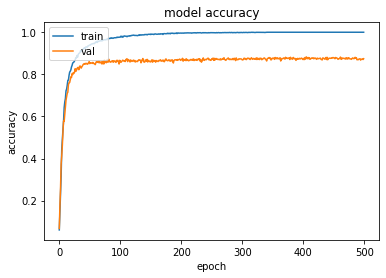

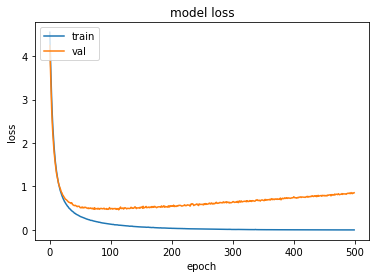

...............

model 1 : ['l2', 'drop', 'epochs']  =  [0.01, 1.0, 500]
Accuracy:  0.7996127783155856
Precision:  0.784525995413399
Recall:  0.7686913811067076
F1 score:  0.7526084952469221


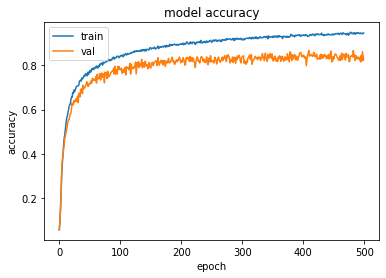

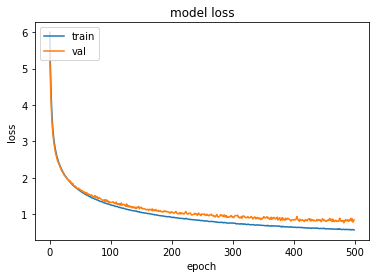

...............

model 2 : ['l2', 'drop', 'epochs']  =  [0.01, 0.25, 500]
Accuracy:  0.8325266214908035
Precision:  0.801036352122438
Recall:  0.7776071352020811
F1 score:  0.7678810756645114


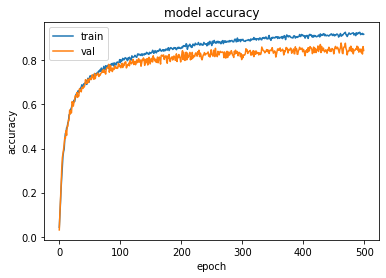

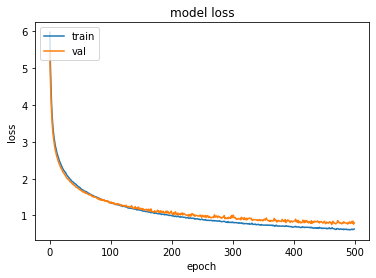

...............

model 3 : ['l2', 'drop', 'epochs']  =  [0.01, 0.5, 800]
Accuracy:  0.8402710551790901
Precision:  0.7802647672472762
Recall:  0.7908254172008794
F1 score:  0.7699809735457164


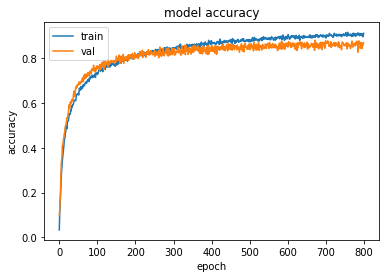

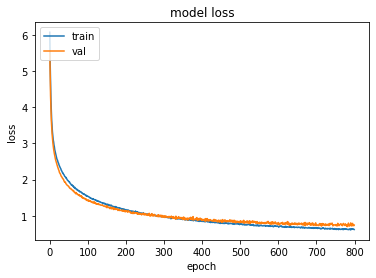

...............

model 4 : ['l2', 'drop', 'epochs']  =  [0.01, 0.6, 800]
Accuracy:  0.8363988383349468
Precision:  0.7938051355090637
Recall:  0.7914093088646755
F1 score:  0.7766761623680045


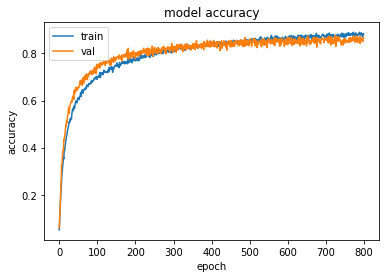

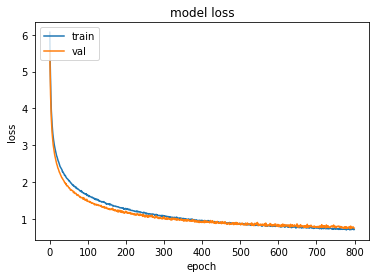

...............



In [168]:
# loss plots for 129/256/122 model
for i,par in enumerate(netw_params_3L):
  print("model",i,":", netw_params_3L_ref," = ",par)
  reportMetrics(globals()["model"+str(i)], X_test_scaled, y_test)
  lossAccuracyPlots(globals()["history"+str(i)])
  print("...............\n")

In [126]:
# checking loss, acccuracy
test_score = model4.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing loss:", test_score[0])
print("Testing accuracy:", test_score[1])

Testing loss: 0.7961868085796582
Testing accuracy: 0.8363988399505615


# 4-layer model

In [177]:
# model: 129/512/256/122
for i,par in enumerate(netw_params_4L):
  print(netw_params_4L_ref)
  print(par)
  globals()["model"+str(i)], globals()["history"+str(i)] = buildNeuralNet(4, par)
  print("...............")

['l2', 'drop1', 'drop2', 'epochs']
[0.0, 1.0, 1.0, 300]
Train on 3097 samples, validate on 1033 samples
Epoch 1/300
3097/3097 [==============================] - 0s 102us/step - loss: 4.4266 - accuracy: 0.0798 - val_loss: 3.9164 - val_accuracy: 0.1684
Epoch 2/300
3097/3097 [==============================] - 0s 70us/step - loss: 3.4707 - accuracy: 0.2367 - val_loss: 2.9978 - val_accuracy: 0.2875
Epoch 3/300
3097/3097 [==============================] - 0s 67us/step - loss: 2.6521 - accuracy: 0.3820 - val_loss: 2.3227 - val_accuracy: 0.3911
Epoch 4/300
3097/3097 [==============================] - 0s 70us/step - loss: 2.0795 - accuracy: 0.4850 - val_loss: 1.8947 - val_accuracy: 0.4918
Epoch 5/300
3097/3097 [==============================] - 0s 66us/step - loss: 1.6835 - accuracy: 0.5699 - val_loss: 1.5710 - val_accuracy: 0.5373
Epoch 6/300
3097/3097 [==============================] - 0s 68us/step - loss: 1.4122 - accuracy: 0.6332 - val_loss: 1.3427 - val_accuracy: 0.6292
Epoch 7/300
3097/30

model 0 : ['l2', 'drop1', 'drop2', 'epochs'] = [0.0, 1.0, 1.0, 300]
Accuracy:  0.8586640851887706
Precision:  0.7906765898879236
Recall:  0.7847134466105191
F1 score:  0.7754896607412503


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


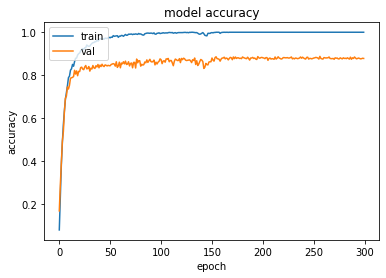

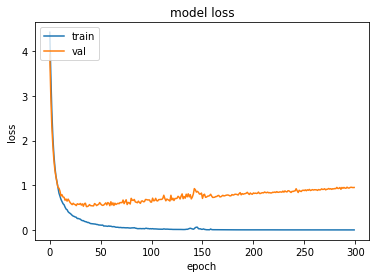

...............

model 1 : ['l2', 'drop1', 'drop2', 'epochs'] = [0.01, 1.0, 1.0, 300]
Accuracy:  0.8286544046466602
Precision:  0.7734146403371034
Recall:  0.7609111235411551
F1 score:  0.7496305374283068


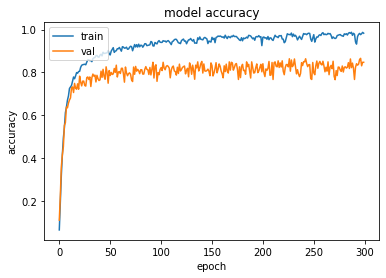

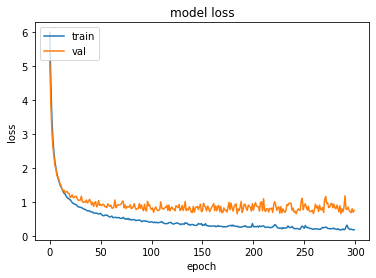

...............

model 2 : ['l2', 'drop1', 'drop2', 'epochs'] = [0.01, 0.25, 0.25, 300]
Accuracy:  0.8431752178121975
Precision:  0.7775546152465526
Recall:  0.771673264621564
F1 score:  0.7593358164530122


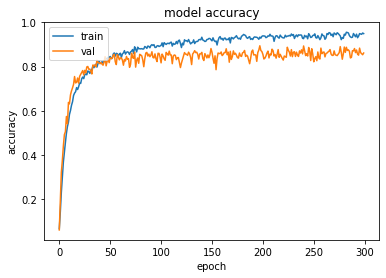

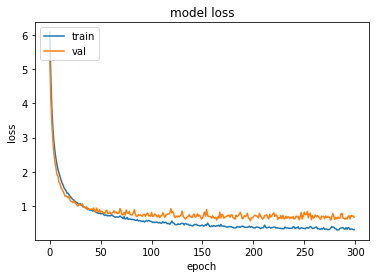

...............

model 3 : ['l2', 'drop1', 'drop2', 'epochs'] = [0.01, 0.5, 0.5, 300]
Accuracy:  0.8092933204259438
Precision:  0.7631094088259536
Recall:  0.7645010128696448
F1 score:  0.7394782195300741


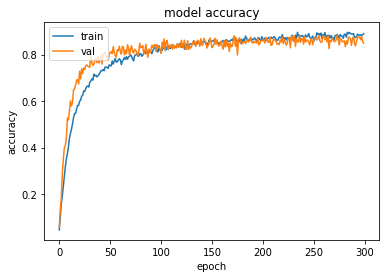

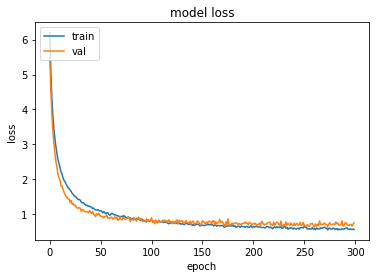

...............

model 4 : ['l2', 'drop1', 'drop2', 'epochs'] = [0.01, 0.5, 0.6, 300]
Accuracy:  0.8373668925459826
Precision:  0.7734800293593015
Recall:  0.7774135861606026
F1 score:  0.7503479031765752


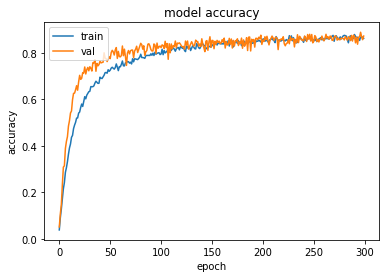

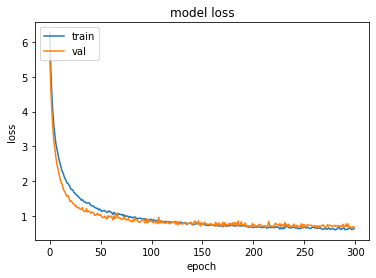

...............



In [178]:
# loss plots for 129/512/256/122 model
for i,par in enumerate(netw_params_4L):
  print("model",i,":",netw_params_4L_ref,"=",par)
  reportMetrics(globals()["model"+str(i)], X_test_scaled, y_test)
  lossAccuracyPlots(globals()["history"+str(i)])
  print("...............\n")

In [179]:
# checking loss, accuracy
test_score = model4.evaluate(X_test_scaled, y_test, verbose=0)
print("Testing loss:", test_score[0])
print("Testing accuracy:", test_score[1])

Testing loss: 0.7772212335470223
Testing accuracy: 0.8373668789863586
